## Homework 6 
#### Portfolio Theory & Risk Management (Fall 2024)
#### Brian Wickman

In [41]:
from cgitb import small

from fontTools.misc.cython import returns
from numexpr.expressions import long_
# Preparation
from pure_eval.utils import typing_annotation_types
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import warnings

from statsmodels.iolib.summary import summary

warnings.filterwarnings("ignore")
sns.set_theme()


### 1. The Momentum Product
(a)  What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

Available to retail investors as a mutual fund as opposed to previous momentum strategies that were gatekept by hedge funds. This poses a few new challenges to AQR: (1, long-only) mutual funds have short-selling constraints and (2, open-end) investors can withdraw capital at any time, potentially forcing AQR to unwind short positions at inopportune times.

(b) Name three reasons the momentum investment product will not exactly track the momentum index, (i.e. why the strategy will have tracking error).

1. Fama-French UMD was long-short.
2. Index assumes monthly rebalancing, irrespective of transaction costs.
3. Transaction costs and tax implications could eat into the strategy's profitability.

(c) When constructing the momentum portfolio, AQR ranks stocks on their returns from month t−12 through t−2. Why don’t they include the t−1 return in this ranking?

AQR also uses short-term reversal strategies, which predicts that over short time horizons, return performance is likely to reverse. By removing the (t-1) return, AQR circumvents potential strategy 'clashes' within the fund.

In [42]:
# Helper functions
def summary_stats(return_data, subsample_dates, mkt_factor, hml_factor, annualization = 12):
    """
        Returns the Performance Stats for given set of returns
        Inputs:
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio, skewness, correlations
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    summary_stats['Skewness'] = return_data.skew()
    
    return_data['MKT'] = mkt_factor
    return_data['HML'] = hml_factor
    corrs = return_data.corr()
    summary_stats['Corr(MKT)'] = corrs.iloc[0,1]
    summary_stats['Corr(HML)'] = corrs.iloc[0,2]

    # label subsample
    subsample_years = subsample_dates[0][:4] + '-' + subsample_dates[1][:4]
    summary_stats.index = [subsample_years]

    return summary_stats

### 2. Investigating Momentum (AQR)

In [43]:
# read data
FILEIN = 'data/momentum_data.xlsx'

factors = pd.read_excel(FILEIN, sheet_name='factors (excess returns)').set_index('Date')
momentum = pd.read_excel(FILEIN, sheet_name='momentum (excess returns)').set_index('Date')
deciles = pd.read_excel(FILEIN, sheet_name='deciles (total returns)').set_index('Date')
size_momentum = pd.read_excel(FILEIN, sheet_name='size_sorts (total returns)').set_index('Date')
rf_rate = pd.read_excel(FILEIN, sheet_name='risk-free rate').set_index('Date')

#### 2.1. Is momentum still profitable?

In [44]:
subsample_dates = [
    ('1927-01-01', '2024-12-31'),
    ('1927-01-01', '1993-12-31'),
    ('1994-01-01', '2008-12-31'),
    ('2009-01-01', '2024-12-31')
]

subsamples = {}
for start_date, end_date in subsample_dates:
    mask = (momentum.index >= start_date) & (momentum.index <= end_date)
    subsamples[(start_date, end_date)] = momentum.loc[mask]

subsample_summary_stats = []
for date_range, subsample in subsamples.items():
    results = summary_stats(subsample[['UMD']], subsample_dates = date_range, mkt_factor=factors[['MKT']], hml_factor = factors[['HML']])
    subsample_summary_stats.append(results.round(4))

formatted_results = pd.concat(subsample_summary_stats)
print("Table 1: Momentum Performance Over Time")
display(formatted_results)


Table 1: Momentum Performance Over Time


,Mean,Volatility,Sharpe Ratio,Skewness,Corr(MKT),Corr(HML)
1927-2024,0.0753,0.1625,0.4635,-2.9905,-0.3443,-0.4064
1927-1993,0.0901,0.1600,0.5630,-3.8082,-0.3625,-0.4950
1994-2008,0.1044,0.1756,0.5945,-0.5820,-0.2345,-0.1294
2009-2024,-0.0151,0.1585,-0.0952,-2.6910,-0.3676,-0.3209


#### (1b) Has momentum changed much over time, as seen through these subsample statistics?

Yes, momentum produced relatively consistent mean and risk-adjusted excess returns (even after the original paper in 1993). However, from 2009-2024, momentum's performance strongly declined; the mean excess return was negative.

#### (1c) Does this data support AQR’s argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs—would there still be evidence here that momentum is valuable?

Even if the momentum factor offers zero excess returns, the factor could provide valuable portfolio diversification through low correlations with MKT and HML factors. The post-GFC market period has demonstrated low volatility (with the exception of COVID-19), whereas we know that momentum performs better during periods of market stress as the strategy 'exploits' human cognitive biases.

#### 2. Is long-only momentum valuable?

In [45]:
long_momentum = 1/2 * (size_momentum['BIG HiPRIOR'] + size_momentum['SMALL HiPRIOR']) - rf_rate['RF']
long_momentum_df = long_momentum.to_frame(name = 'UMD')

# Subsample
subsample_start = '1994-01-01'
subsample_end = '2024-12-31'
long_momentum_subsample = long_momentum_df.loc[subsample_start:subsample_end]

# Summary stats
subsample_period = (subsample_start, subsample_end)
print("Table 2a: Long-Only Momentum Performance")
long_subsample_results = summary_stats(long_momentum_subsample[['UMD']], subsample_dates = subsample_period, mkt_factor=factors[['MKT']], hml_factor = factors[['HML']])
display(long_subsample_results.round(4))

print("Table 2b: Long-Short Momentum Performance")
long_short_subsample_results = results = summary_stats(momentum[['UMD']].loc[subsample_start:subsample_end], subsample_dates = subsample_period, mkt_factor=factors[['MKT']], hml_factor = factors[['HML']])
display(long_short_subsample_results.round(4))

Table 2a: Long-Only Momentum Performance


,Mean,Volatility,Sharpe Ratio,Skewness,Corr(MKT),Corr(HML)
1994-2024,0.1172,0.1784,0.6569,-0.4448,0.9036,-0.119


Table 2b: Long-Short Momentum Performance


,Mean,Volatility,Sharpe Ratio,Skewness,Corr(MKT),Corr(HML)
1994-2024,0.0432,0.1677,0.2575,-1.446,-0.3062,-0.2152


#### (2b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

Long-only momentum is more attractive during this period with a higher mean and Sharpe ratio because the market performed very well over this period.

#### (2c)  Is long-only momentum as diversifying as long-short momentum with respect to market and value premia? 

Long-only momentum has .904 correlation with the market, but is uncorrelated (by construction) with the value factor. These results show that the negative excess returns of the long-short momentum strategy are due to shorting the stocks in the bottom three deciles of momentum, which makes sense as the S&P 500 (including low momentum stocks) performed very well over this subsample.


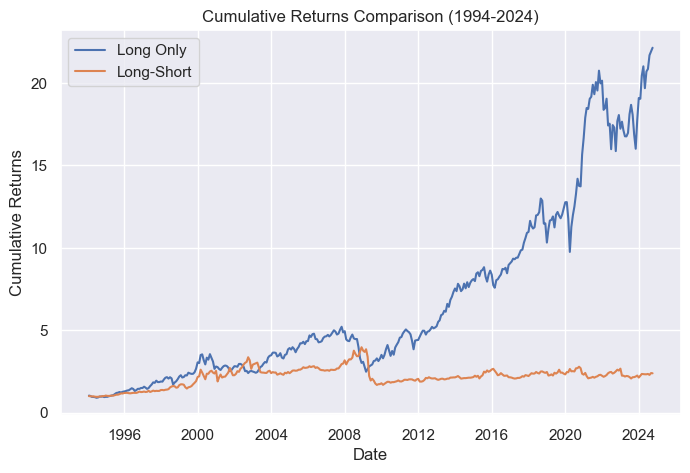

In [46]:
# cumulative returns (kinda, these are excess returns) of long-short vs long momentum portfolios
long_only_cum_returns = (long_momentum_subsample[['UMD']] + 1).cumprod()
long_short_cum_returns = (momentum[['UMD']].loc[subsample_start:subsample_end] + 1).cumprod()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(long_only_cum_returns.index, long_only_cum_returns['UMD'], label='Long Only')
plt.plot(long_short_cum_returns.index, long_short_cum_returns['UMD'], label='Long-Short')
plt.title('Cumulative Returns Comparison (1994-2024)')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

#### 3. Is momentum just data-mining or is it a robust strategy?

In [47]:
# construct portfolios for robustness (d = decile #)
returns_d1 = (deciles['Hi PRIOR'] - deciles['Lo PRIOR']).to_frame('D1')
returns_d3 = (1/3)*(deciles[['Hi PRIOR', 'PRIOR 9', 'PRIOR 8']].sum(axis=1) - deciles[['Lo PRIOR', 'PRIOR 2', 'PRIOR 3']].sum(axis=1)).to_frame('D3')
returns_d5 = (1/5)*(deciles[['Hi PRIOR', 'PRIOR 9', 'PRIOR 8', 'PRIOR 7', 'PRIOR 6']].sum(axis=1) - deciles[['Lo PRIOR', 'PRIOR 2', 'PRIOR 3', 'PRIOR 4', 'PRIOR 5']].sum(axis=1)).to_frame('D5')

# subsample
subsample_start = '1994-01-01'
subsample_end = '2024-12-31'
subsample_period = (subsample_start, subsample_end)

decile_portfolios = [returns_d1, returns_d3, returns_d5]
decile_summary_stats = []
for value in range(3):
    tmp_decile_portfolio = decile_portfolios[value].loc[subsample_start:subsample_end].iloc[:,[0]]
    decile_results = summary_stats(tmp_decile_portfolio, subsample_dates = subsample_period, mkt_factor=factors[['MKT']], hml_factor = factors[['HML']])
    decile_summary_stats.append(decile_results.round(4))

decile_formatted_results = pd.concat(decile_summary_stats)
decile_formatted_results.index = ["1st Decile", "3rd Decile", "5th Decile"]
print("Table 3: Robustness of momentum construction (1994 - 2024 subsample)")
display(decile_formatted_results)

Table 3: Robustness of momentum construction (1994 - 2024 subsample)


,Mean,Volatility,Sharpe Ratio,Skewness,Corr(MKT),Corr(HML)
1st Decile,0.0820,0.2990,0.2742,-1.3046,-0.3197,-0.2335
3rd Decile,0.0286,0.1934,0.1476,-1.3450,-0.3617,-0.2115
5th Decile,0.0164,0.1340,0.1225,-1.4159,-0.3486,-0.2122


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?
Yes, the 1st decile portfolio has higher returns and higher volatility as opposed to the 3rd and 5th decile portfolios.
#### (c) Should AQR’s retail product consider using a 1-decile or 5-decile construction?
AQR should consider using the 1-decile construction because it has the highest Sharpe ratio and similar correlations with the MKT and HML factors.
#### (d) Does the 3-decile construction have similar stats to the Fama-French construction in (1).
Fama-French UMD displays a higher mean, similar volatility, and higher Sharpe ratio than the 3-decile construction. This is most likely due to UMD considered firm size during factor construction.

#### 4. Does implementing momentum require trading lots of small stocks—thus causing even larger trading costs?

In [48]:
# construct portfolios for robustness (d = decile #)
all_stocks = (1/2)*((size_momentum[['SMALL HiPRIOR', 'BIG HiPRIOR']].sum(axis=1) - size_momentum[['SMALL LoPRIOR', 'BIG LoPRIOR']].sum(axis=1))).to_frame('All')
small_stocks = (size_momentum['SMALL HiPRIOR'] - size_momentum['SMALL LoPRIOR']).to_frame('Small')
big_stocks = (size_momentum['BIG HiPRIOR'] - size_momentum['BIG LoPRIOR']).to_frame('Big')

# subsample
subsample_start = '1994-01-01'
subsample_end = '2024-12-31'
subsample_period = (subsample_start, subsample_end)

size_portfolios = [all_stocks, small_stocks, big_stocks]
size_summary_stats = []
for value in range(3):
    tmp_size_portfolio = size_portfolios[value].loc[subsample_start:subsample_end].iloc[:,[0]]
    size_results = summary_stats(tmp_size_portfolio, subsample_dates = subsample_period, mkt_factor=factors[['MKT']], hml_factor = factors[['HML']])
    size_summary_stats.append(size_results.round(4))

size_formatted_results = pd.concat(size_summary_stats)
size_formatted_results.index = ["All", "Small", "Big"]
print("Table 4: Momentum of small and big stocks (1994 - 2024 subsample)")
display(size_formatted_results)

Table 4: Momentum of small and big stocks (1994 - 2024 subsample)


,Mean,Volatility,Sharpe Ratio,Skewness,Corr(MKT),Corr(HML)
All,0.0432,0.1677,0.2576,-1.4461,-0.3062,-0.2152
Small,0.0632,0.1696,0.3726,-1.7636,-0.3040,-0.1485
Big,0.0232,0.1825,0.1270,-0.8791,-0.2802,-0.2575


#### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Yes, the small stocks display higher mean return and Sharpe ratio compared to the big stocks. Thus, a momenutm strategy with only large stocks, while appealing from a transaction costs perspective, would not have delivered adequate performance over the 1994-2024 subsample.

### AQR Conclusion

 In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?
 
AQR's retail product adds value for retail investors by offering exposure to momentum strategies that only slightly underperform Fama-French's UMD factor. This is admirable because, as discussed in the case study, there were many implementation details left to AQR's discretion, including rebalancing frequency, dealing with boundary stocks, and trading decisions.

### 3. Barnstable's Analysis

Placeholder.

### 4. Estimating Underperformance 

#### 1. Summary Statistics

In [49]:
# Load data
FILEIN = 'data/barnstable_analysis_data.xlsx'
barnstable = pd.read_excel(FILEIN, sheet_name='data').set_index('date')

# Iterate through subsamples, series to fill out Table 5
# Preparation
subsample_dates = [
    ('1965-01-01', '1999-12-31'),
    ('2000-01-01', '2024-12-31'),
    ('1926-01-01', '2024-12-31')
]
series_data = [barnstable['SPX'], factors['MKT'], barnstable['TB1M'],
               np.log(1+barnstable['SPX']), np.log(1+factors['MKT']),
               np.log(1+barnstable['TB1M'])]

ss_summary_stats = [] # aggregate subsample summary stats across series
for tmp_series in series_data: # loop through series
    
    series_stats = [] # aggregate subsample summary stats for a given series
    for i in range(3): # loop through subsamples
        # identify subsample
        tmp_start = pd.to_datetime(subsample_dates[i][0])
        tmp_end = pd.to_datetime(subsample_dates[i][1])
        series_subsample = tmp_series.loc[tmp_start:tmp_end]
        
        # calculate summary stats
        series_stats.append((series_subsample.mean() * 12).round(4)) # mean
        series_stats.append((series_subsample.var() * np.sqrt(12)).round(4)) # vol
        
    ss_summary_stats.append(series_stats)

# Format results
barnstable_summary_stats = pd.DataFrame(ss_summary_stats, columns=['(1965-1999): Mean', 'Vol',
                                             '(2000-2024): Mean', 'Vol',
                                             '(1926-2024): Mean', 'Vol'])
barnstable_summary_stats.index = ['SPX (Level)', 'MKT (Level)', 'TB1M (Level)', 'SPX (Log)', 'MKT (Log)', 'TB1M (Log)']

# Display results
display(barnstable_summary_stats)

,(1965-1999): Mean,Vol,(2000-2024): Mean,Vol,(1926-2024): Mean,Vol
SPX (Level),0.1294,0.0064,0.0873,0.0068,0.1155,0.0101
MKT (Level),0.0673,0.0070,0.0705,0.0073,0.0820,0.0099
TB1M (Level),0.0615,0.0000,0.0172,0.0000,0.0319,0.0000
SPX (Log),0.1176,0.0065,0.0753,0.0068,0.0978,0.0100
MKT (Log),0.0549,0.0071,0.0576,0.0074,0.0647,0.0099
TB1M (Log),0.0613,0.0000,0.0172,0.0000,0.0318,0.0000


#### (b) Comment on how the full-sample return stats compare to the sub-sample stats.

The full sample returns stats for SPX and MKT are quite similar across subsamples. However, the TB1M, our proxy for the risk-free rate, has a mean of 6.2% in the first period and a mean of 3.2% in the second period. From Barnstable's perspective, it makes sense that they estimated the risk-free rate to be 6% in the monetary policy environment of the late 1900s.

#### (c) Comment on how the level stats compare to the log stats.

The level and log stats are very similar, as expected, because for small numbers, the log function (log(1+x)) is very close to x itself.

#### 2. Probability of Underperformance

In [50]:
from scipy.stats import norm
# Function to calculate probability of underperformance
def underperformance_probability(spx_returns, tbill_returns, n_years):
    
    # Calculate log returns for both S&P 500 and T-bill
    spx_log_ret = np.log(1 + spx_returns)
    tbill_log_ret = np.log(1 + tbill_returns)

    # Cumulative log returns over n_years
    n_months = n_years * 12
    cum_spx_log_ret = spx_log_ret.rolling(window=n_months).sum()
    cum_tbill_log_ret = tbill_log_ret.rolling(window=n_months).sum()

    # Mean and standard deviation of differences in log returns
    # Z = SPX - RF_RATE
    mean_z = np.mean(cum_spx_log_ret) - np.mean(cum_tbill_log_ret) # subtract means
    var_z = np.var(cum_spx_log_ret) + np.var(cum_tbill_log_ret) # add variances

    # Standardize L
    L = -(mean_z / np.sqrt(var_z))

    # Calculate probability using normal CDF
    prob_z_less_than_0 = norm.cdf(L)

    return prob_z_less_than_0

In [51]:
# Subsample 1965 - 1999
barnstable_ss = barnstable.loc['1965-01-01':'1999-12-31']
cum_return_spx = np.log(1 + barnstable_ss['SPX'])
cum_return_tbill = np.log(1 + barnstable_ss['TB1M'])
ss_underperformance = norm.cdf(-(cum_return_spx.sum() - cum_return_tbill.sum())/(np.sqrt(cum_return_spx.var() + cum_return_tbill.var())))

# Calculate underperformance prob over n_periods
n_period_p = []
for i in range(35):
    tmp_val = underperformance_probability(barnstable_ss['SPX'], barnstable_ss['TB1M'], n_years = (i+1))
    n_period_p.append(tmp_val.round(4))
    
print(f'Probability that the cumulative market return will fall short of cumulative risk-free rate in x years:\n'
      f'Full sample (35 years): {ss_underperformance.round(4)}\n'
      f'30 years: {n_period_p[29].round(4)}\n'
      f'15 years: {n_period_p[14].round(4)}\n')

Probability that the cumulative market return will fall short of cumulative risk-free rate in x years:
Full sample (35 years): 0.0
30 years: 0.0
15 years: 0.0997



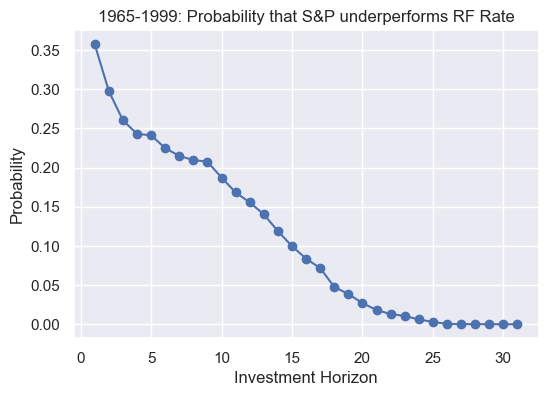

In [52]:
# Probability as a function of investment horizon
x_values = list(range(1, 36))
plt.figure(figsize=(6, 4))
plt.plot(x_values, n_period_p, marker='o', linestyle='-')
plt.title('1965-1999: Probability that S&P underperforms RF Rate')
plt.xlabel('Investment Horizon')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

Probability that the cumulative market return will fall short of cumulative risk-free rate in 30 years 0.001


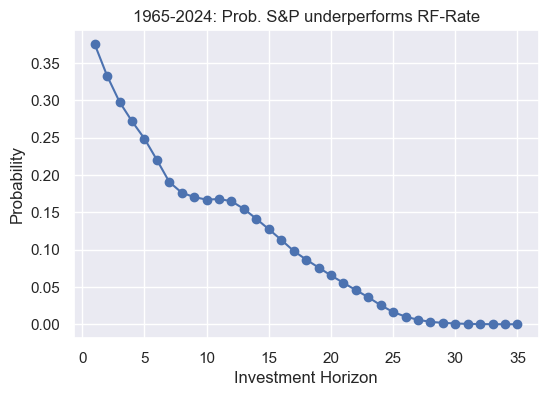

In [53]:
# Full sample underperformance probability
cum_return_spx = np.log(1 + barnstable['SPX'])
cum_return_tbill = np.log(1 + barnstable['TB1M'])
ss_underperformance = norm.cdf(-(cum_return_spx.sum() - cum_return_tbill.sum())/(np.sqrt(cum_return_spx.var() + cum_return_tbill.var())))

# Calculate underperformance prob over n_periods
full_n_period_p = []
for i in range(35):
    tmp_val = underperformance_probability(barnstable['SPX'], barnstable['TB1M'], n_years = (i+1))
    full_n_period_p.append(tmp_val.round(4))

print(f'Probability that the cumulative market return will fall short of cumulative risk-free rate in 30 years {full_n_period_p[29]}')

# Probability as a function of investment horizon
x_values = list(range(1, 36))
plt.figure(figsize=(6, 4))
plt.plot(x_values, full_n_period_p, marker='o', linestyle='-')
plt.title('1965-2024: Prob. S&P underperforms RF-Rate')
plt.xlabel('Investment Horizon')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

In [54]:
# Probability that 25-year S&P return < realized in 2000-2024
barnstable_pre = barnstable.loc['1975-01-01':'1999-12-31'] # use previous 25 years to make compound return fair
barnstable_post = barnstable.loc['2000-01-01':]
cum_ret_spx_99 = np.log(1 + barnstable_pre['SPX']) # pre-barnstable data
cum_ret_spx_24 = np.log(1 + barnstable_post['SPX']) # post-barnstable update


barnstable_accuracy = norm.cdf((cum_ret_spx_24.sum() - cum_ret_spx_99.sum())/np.sqrt(cum_ret_spx_99.var()))
print(f'Prob of 2000-2024 SPX return < Barnstables expectation of SPX return: {barnstable_accuracy}\n'
      f'This is very low because the market returns were large w/ little variance during Barnstables sample period (see summary stats below).')

print(f'Cumulative market return (2000-2024): {cum_ret_spx_24.sum().round(4)}\n'
      f'Cumulative market return (1975-1999): {cum_ret_spx_99.sum().round(4)}\n'
      f'SD of market returns (1975-1999): {np.sqrt(cum_ret_spx_99.var()).round(4)}')

Prob of 2000-2024 SPX return < Barnstables expectation of SPX return: 0.0
This is very low because the market returns were large w/ little variance during Barnstables sample period (see summary stats below).
Cumulative market return (2000-2024): 1.8626
Cumulative market return (1975-1999): 3.992
SD of market returns (1975-1999): 0.0431
